In [1]:
# Test script using the default_material function to define geometry with NumPy arrays.
# Model is a simple cylinder. Results will be compared against those using GeometricObjects.

import meep as mp
import numpy as np
import matplotlib.pyplot as plt

Using MPI version 4.0, 1 processes


In [2]:
# grid properties
a   = 1.
wvl = 1.
sx  = 10*wvl # size of grid in x
sy  = 10*wvl # size of grid in y

# cylinder properties
R = 1*a  # radius
n = 1.45 # refractive index

# simulation properties
resolution = 20    # points per a
dpml       = wvl/2 # thickness of pml
pml_layers = [mp.PML(dpml)]
cell_size  = mp.Vector3(sx+2*dpml, sy+2*dpml)

# define sources
sources = [mp.Source(mp.ContinuousSource(wavelength=wvl, is_integrated=True),
                     component=mp.Ey,
                     center=mp.Vector3(x=-sx/2),
                     size=mp.Vector3(y=cell_size.y))]

# Using GeometricObject

     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)


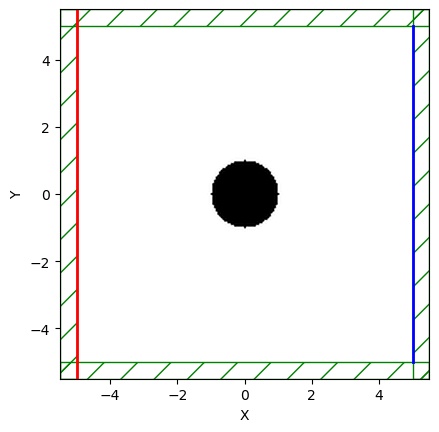

-----------
Initializing structure...
time for choose_chunkdivision = 0.00011638 s
Working in 2D dimensions.
Computational cell is 11 x 11 x 0 with resolution 20
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
time for set_epsilon = 0.0540193 s
-----------


FloatProgress(value=0.0, description='0% done ', max=20.0)

run 0 finished at t = 20.0 (800 timesteps)


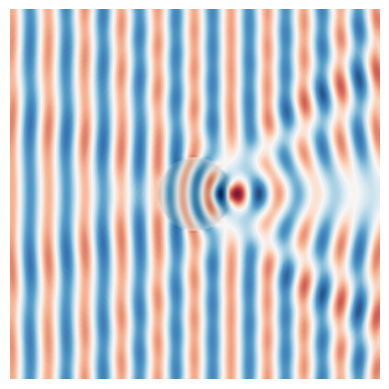

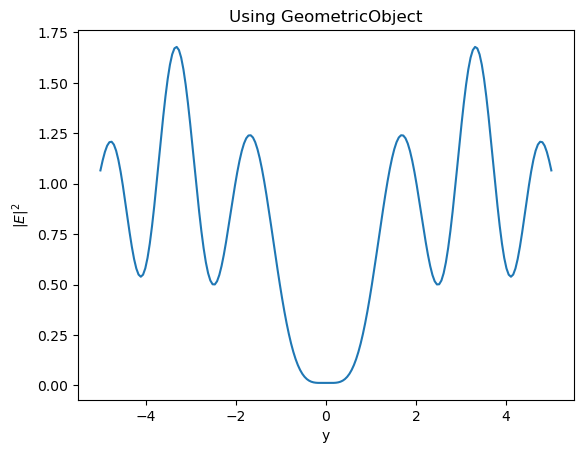

In [3]:
# define geometry
geometry = [mp.Cylinder(center=mp.Vector3(), height=mp.inf, radius=R, axis=mp.Vector3(z=1), material=mp.Medium(index=n))]

# define sim
sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry)

# add field monitor
field_mon = sim.add_dft_fields([mp.Ey], 1/wvl, 0, 1, center=mp.Vector3(sx/2), size=mp.Vector3(y=sy))

# show sim setup
sim.plot2D()
plt.show()

# run simulation
sim.run(until=20*wvl)

# plot steady-state
eps_data1 = sim.get_array(center=mp.Vector3(), size=mp.Vector3(sx, sy), component=mp.Dielectric)
e_data1   = sim.get_array(center=mp.Vector3(), size=mp.Vector3(sx, sy), component=mp.Ey)
plt.figure()
plt.imshow(eps_data1.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(e_data1.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

# grab field data
field_data = sim.get_dft_array(field_mon, mp.Ey, 0)

# plot field data
xaxis      = np.linspace(-sy/2, sy/2, len(field_data))
field_amp1 = np.abs(field_data)**2
plt.plot(xaxis, field_amp1)
plt.title("Using GeometricObject")
plt.xlabel("y")
plt.ylabel("$|E|^{2}$")
plt.show()

# Using default_material

read in 512x512x1 numpy array for epsilon


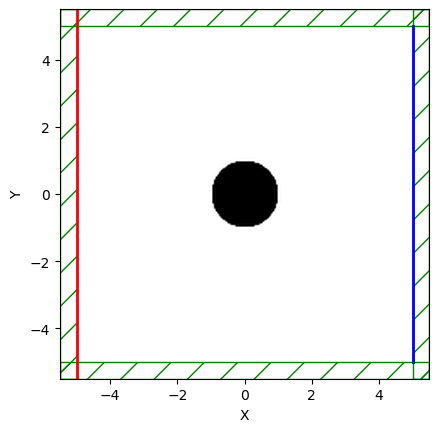

-----------
Initializing structure...
read in 512x512x1 numpy array for epsilon
time for choose_chunkdivision = 0.000107458 s
read in 512x512x1 numpy array for epsilon
Working in 2D dimensions.
Computational cell is 11 x 11 x 0 with resolution 20
time for set_epsilon = 0.0563075 s
-----------


FloatProgress(value=0.0, description='0% done ', max=20.0)

run 0 finished at t = 20.0 (800 timesteps)


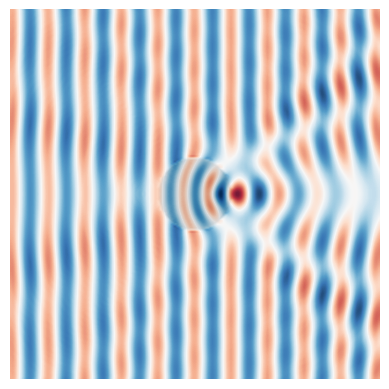

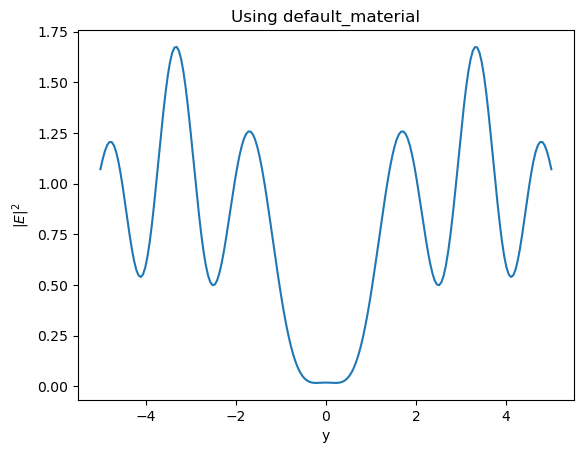

In [4]:
# define lens geometry
def custom_geometry():
    x = np.linspace(-cell_size.x/2, cell_size.x/2, 512) # array bounds need to match the sim!
    y = np.linspace(-cell_size.y/2, cell_size.y/2, 512) # or else geometry can be scaled!
    x,y = np.meshgrid(x,y)
    C = (x**2 + y**2) <= R**2
    C = 1.0 + (n**2 - 1.0)*C
    return C
C = custom_geometry()

# define sim
sim.reset_meep()
sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    sources=sources,
                    default_material=C)

# add field monitor
field_mon = sim.add_dft_fields([mp.Ey], 1/wvl, 0, 1, center=mp.Vector3(sx/2), size=mp.Vector3(y=sy))

# show sim setup
sim.plot2D()
plt.show()

# run simulation
sim.run(until=20*wvl)

# plot steady-state
eps_data2 = sim.get_array(center=mp.Vector3(), size=mp.Vector3(sx, sy), component=mp.Dielectric)
e_data2   = sim.get_array(center=mp.Vector3(), size=mp.Vector3(sx, sy), component=mp.Ey)
plt.figure()
plt.imshow(eps_data2.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(e_data2.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

# grab field data
field_data = sim.get_dft_array(field_mon, mp.Ey, 0)

# plot field data
xaxis      = np.linspace(-sy/2, sy/2, len(field_data))
field_amp2 = np.abs(field_data)**2
plt.plot(xaxis, field_amp2)
plt.title("Using default_material")
plt.xlabel("y")
plt.ylabel("$|E|^{2}$")
plt.show()

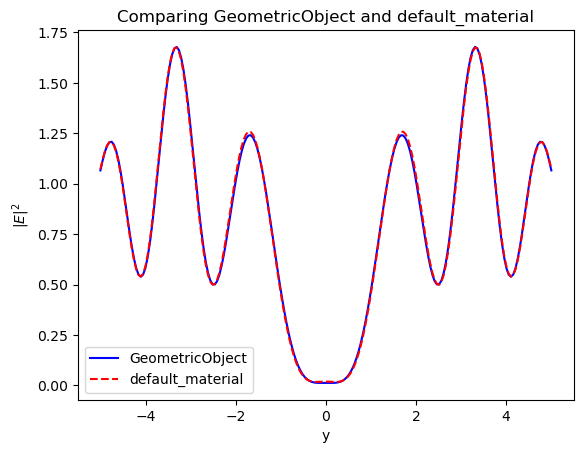

In [6]:
# compare field amplitude data
plt.plot(xaxis, field_amp1, 'b', label="GeometricObject")
plt.plot(xaxis, field_amp2, 'r--', label="default_material")
plt.legend()
plt.title("Comparing GeometricObject and default_material")
plt.xlabel("y")
plt.ylabel("$|E|^{2}$")
plt.show()

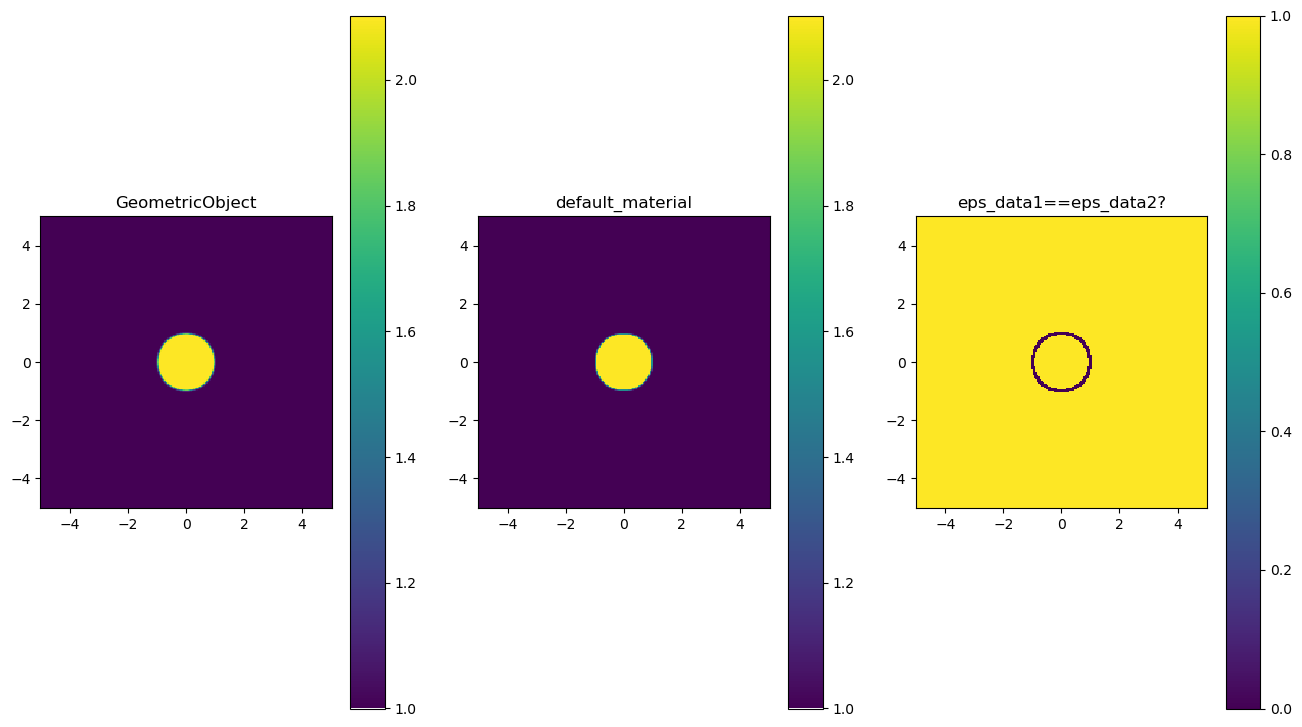

In [12]:
# compare epsilon data
xaxis = np.linspace(-sx/2, sx/2, np.shape(eps_data1)[0])
yaxis = np.linspace(-sy/2, sy/2, np.shape(eps_data1)[1])

plt.figure(figsize=(16,9))
plt.subplot(1,3,1)
plt.pcolormesh(xaxis, yaxis, eps_data1)
plt.colorbar()
plt.axis('scaled')
plt.title("GeometricObject")

plt.subplot(1,3,2)
plt.pcolormesh(xaxis, yaxis, eps_data2)
plt.axis('scaled')
plt.colorbar()
plt.title("default_material")

plt.subplot(1,3,3)
plt.pcolormesh(xaxis, yaxis, eps_data1==eps_data2)
plt.axis('scaled')
plt.colorbar()
plt.title("eps_data1==eps_data2?")

plt.show()